# Exploring Foursquare POI Data


1. [Foursquare's 104M Points of Interest](https://tech.marksblogg.com/foursquare-open-global-poi-dataset.html)

In [ ]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.0/116.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import duckdb
import os
import pandas as pd
import geopandas as gpd

Foursquare POI count in India
1. Feb 2025 Release = `12.87` Lakhs
2. Aug 2025 Relase = `13.67` Lakhs

In [ ]:
!wget https://raw.githubusercontent.com/udit-001/india-maps-data/main/geojson/india.geojson -O india.geojson

--2025-08-02 15:18:02--  https://raw.githubusercontent.com/udit-001/india-maps-data/main/geojson/india.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3848537 (3.7M) [text/plain]
Saving to: ‘india.geojson’

india.geojson       100%[===================>]   3.67M  --.-KB/s    in 0.05s   

2025-08-02 15:18:03 (68.0 MB/s) - ‘india.geojson’ saved [3848537/3848537]



<Axes: >

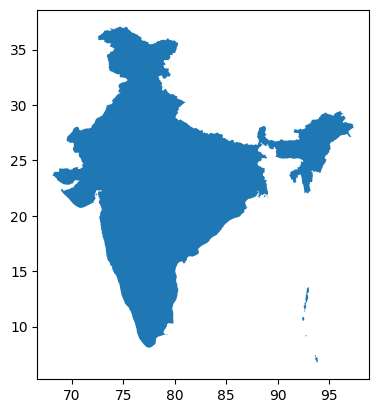

In [ ]:
gdf = gpd.read_file('india.geojson')
india_gdf = gdf.dissolve()
india_gdf.to_parquet('india.parquet')
india_gdf.plot()

In [ ]:
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

## Get Starbucks in India

In [ ]:
%%time

# Initialize DuckDB connection
con = duckdb.connect()

# Load the spatial extension if not already loaded
con.execute("INSTALL spatial;")
con.execute("LOAD spatial;")

# Define the output parquet file name
output_parquet_file = 'poi_india.parquet'

# Execute the query and directly copy the results to a parquet file
query = f"""
    COPY (
        SELECT * FROM read_parquet('s3://overturemaps-us-west-2/release/2025-07-23.0/theme=places/*/*') AS POI
        JOIN read_parquet('india.parquet') as INDIA
        ON ST_Within(POI.geometry, INDIA.geometry) LIMIT 100
    ) TO '{output_parquet_file}' (FORMAT PARQUET);
"""
con.execute(query)

print(f"Query results saved to {output_parquet_file}")

# Close the DuckDB connection
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Query results saved to poi_india.parquet
CPU times: user 1min 30s, sys: 7.9 s, total: 1min 38s
Wall time: 3min 9s


In [ ]:
df = pd.read_parquet("poi_india.parquet")
df['categories'].iloc[0]

{'primary': 'hotel', 'alternate': array(['resort', 'beach'], dtype=object)}

## Caategory Wise Count

In [ ]:
%%time

# Initialize DuckDB connection
con = duckdb.connect()

s3_path = ''
df = duckdb.sql(
    f"""
        INSTALL spatial;
        LOAD spatial;

        SELECT
            POI.categories.primary as Category,
            COUNT(POI.id) as Total_Count
        FROM read_parquet('s3://overturemaps-us-west-2/release/2025-07-23.0/theme=places/*/*') AS POI
        JOIN read_parquet('india.parquet') as INDIA
        ON ST_Within(POI.geometry, INDIA.geometry)
        GROUP BY POI.categories.primary;
    """
)

print(df)

# Close the DuckDB connection
con.close()

BinderException: Binder Error: column "categories" must appear in the GROUP BY clause or must be part of an aggregate function.
Either add it to the GROUP BY list, or use "ANY_VALUE(categories)" if the exact value of "categories" is not important.

In [ ]:
df.df()

duckdb.duckdb.DuckDBPyRelation

## Categories Master Table

In [ ]:
# Initialize DuckDB connection
con = duckdb.connect()

# Load the httpfs extension to enable S3 access
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

s3_path = f's3://fsq-os-places-us-east-1/release/dt=2025-07-08/categories/parquet/categories.zstd.parquet'
# Execute the COPY command to read from S3 and write to a Parquet file
query = f"COPY (SELECT * FROM read_parquet('{s3_path}')) TO 'categories.parquet' (FORMAT PARQUET);"
con.execute(query)

# Close the DuckDB connection
con.close()

In [ ]:
df = pd.read_parquet('categories.parquet')
df.shape

(1245, 17)

In [ ]:
print(df['category_label'].iloc[10])

Health and Medicine > Physician > Geriatric Doctor


In [ ]:
df[df['category_level']==3]

,category_id,category_level,category_name,category_label,level1_category_id,level1_category_name,level2_category_id,level2_category_name,level3_category_id,level3_category_name,level4_category_id,level4_category_name,level5_category_id,level5_category_name,level6_category_id,level6_category_name,dt
0,63be6904847c3692a84b9c0c,3,Hockey Club,Sports and Recreation > Hockey > Hockey Club,4f4528bc4b90abdf24c9de85,Sports and Recreation,63be6904847c3692a84b9c0b,Hockey,63be6904847c3692a84b9c0c,Hockey Club,None,None,None,None,None,None,2025-07-08
2,4bf58dd8d48988d117951735,3,Candy Store,Retail > Food and Beverage Retail > Candy Store,4d4b7105d754a06378d81259,Retail,4bf58dd8d48988d1f9941735,Food and Beverage Retail,4bf58dd8d48988d117951735,Candy Store,None,None,None,None,None,None,2025-07-08
4,4bf58dd8d48988d189941735,3,Football Stadium,Arts and Entertainment > Stadium > Football St...,4d4b7104d754a06370d81259,Arts and Entertainment,4bf58dd8d48988d184941735,Stadium,4bf58dd8d48988d189941735,Football Stadium,None,None,None,None,None,None,2025-07-08
5,56aa371be4b08b9a8d573566,3,Ski Store,Retail > Sporting Goods Retail > Ski Store,4d4b7105d754a06378d81259,Retail,4bf58dd8d48988d1f2941735,Sporting Goods Retail,56aa371be4b08b9a8d573566,Ski Store,None,None,None,None,None,None,2025-07-08
6,63be6904847c3692a84b9b31,3,Transmissions Shop,Business and Professional Services > Automotiv...,4d4b7105d754a06375d81259,Business and Professional Services,63be6904847c3692a84b9b2b,Automotive Service,63be6904847c3692a84b9b31,Transmissions Shop,None,None,None,None,None,None,2025-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,4eb1bdf03b7b55596b4a7491,3,Camera Store,Retail > Computers and Electronics Retail > Ca...,4d4b7105d754a06378d81259,Retail,63be6904847c3692a84b9bea,Computers and Electronics Retail,4eb1bdf03b7b55596b4a7491,Camera Store,None,None,None,None,None,None,2025-07-08
1237,52e81612bcbc57f1066b7a0d,3,Beach Bar,Dining and Drinking > Bar > Beach Bar,63be6904847c3692a84b9bb5,Dining and Drinking,4bf58dd8d48988d116941735,Bar,52e81612bcbc57f1066b7a0d,Beach Bar,None,None,None,None,None,None,2025-07-08
1238,58daa1558bbb0b01f18ec1f7,3,Hospital Unit,Health and Medicine > Hospital > Hospital Unit,63be6904847c3692a84b9bb9,Health and Medicine,4bf58dd8d48988d196941735,Hospital,58daa1558bbb0b01f18ec1f7,Hospital Unit,None,None,None,None,None,None,2025-07-08
1243,56aa371be4b08b9a8d5734fc,3,Confucian Temple,Community and Government > Spiritual Center > ...,63be6904847c3692a84b9b9a,Community and Government,4bf58dd8d48988d131941735,Spiritual Center,56aa371be4b08b9a8d5734fc,Confucian Temple,None,None,None,None,None,None,2025-07-08


In [ ]:
categories = df['category_label'].str.split(">").to_list()
max_cols = max([len(i) for i in categories])

df_cat = pd.DataFrame(categories, columns=[f'category_level_{i}' for i in range(1,max_cols+1)])
for col in df_cat.columns:
    df_cat[col] = df_cat[col].str.strip()
df_cat.head()

,category_level_1,category_level_2,category_level_3,category_level_4,category_level_5,category_level_6
0,Sports and Recreation,Hockey,Hockey Club,None,None,None
1,Dining and Drinking,Restaurant,Asian Restaurant,Indonesian Restaurant,Indonesian Meatball Restaurant,None
2,Retail,Food and Beverage Retail,Candy Store,None,None,None
3,Dining and Drinking,Restaurant,Asian Restaurant,Satay Restaurant,None,None
4,Arts and Entertainment,Stadium,Football Stadium,None,None,None


In [ ]:
df_cat['category_level_1'].value_counts()

,count
category_level_1,
Dining and Drinking,393
Business and Professional Services,195
Retail,150
Community and Government,127
Sports and Recreation,87
Travel and Transportation,72
Arts and Entertainment,72
Landmarks and Outdoors,71
Health and Medicine,59


In [ ]:
df_cat[df_cat['category_level_1']=='Travel and Transportation']['category_level_2'].unique()

array(['Lodging', 'Travel Agency', 'Transport Hub', 'Baggage Locker',
       'Hot Air Balloon Tour Agency', 'Platform', 'Cable Car',
       'Transportation Service', 'Bike Rental', 'Cruise',
       'Border Crossing', 'Boat Rental', 'Rest Area', 'RV Park',
       'Fuel Station', 'Pier', 'Toll Plaza', 'Street', 'General Travel',
       'Travel Lounge', 'Tourist Information and Service',
       'Boat or Ferry', 'Electric Vehicle Charging Station', 'Train',
       'Moving Target', 'Toll Booth', 'Road', 'Parking', None, 'Port',
       'Truck Stop'], dtype=object)